In [1]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
import os
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq


%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
SURF_WINDOW = 20
DCT_WINDOW = 20
windowSize = 10

class colorizer():
    def __init__(self,n_pixels=100,n_colors=16):
        self.n_pixels=n_pixels
        self.n_colors=n_colors
        self.n_samples=0
        self.clf=MLP(hidden_layer_sizes=(800,400,),solver='lbfgs',verbose=True,learning_rate='adaptive',tol=1e-9)
        self.centroids=None
        self.surf = cv2.xfeatures2d.SURF_create()
        self.color_to_label_map = {}
        self.label_to_color_map = {}
        #self.surf.setBool('extended', True) #use the 128-length descriptors
    
    def load_dataset(self,folder='dataset'):
        l_ch=[]
        a_ch=[]
        b_ch=[]
        self.n_samples=len(os.listdir(folder))
        for file in os.listdir(folder):
            l,a,b=cv2.split(cv2.cvtColor(cv2.imread(folder+'/'+file), cv2.COLOR_BGR2Lab))
            l_ch.append(l)
            a_ch.append(a)
            b_ch.append(b)
        return np.array(l_ch),np.array(a_ch),np.array(b_ch)

    

    def feature_surf(self, img, pos):
        '''
        Gets the SURF descriptor of img at pos = (x,y).
        Assume img is a single channel image.
        '''
        octave2 = cv2.GaussianBlur(img, (0, 0), 1)
        octave3 = cv2.GaussianBlur(img, (0, 0), 2)
        kp = cv2.KeyPoint(pos[0], pos[1], SURF_WINDOW)
        _, des1 = self.surf.compute(img, [kp])
        _, des2 = self.surf.compute(octave2, [kp])
        _, des3 = self.surf.compute(octave3, [kp])

        return np.concatenate((des1[0], des2[0], des3[0]))

    def feature_dft(self, img, pos):
        xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
        ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
        patch = img[ylim[0]:ylim[1],xlim[0]:xlim[1]]
        
        l = (2*windowSize + 1)**2

        #return all zeros for now if we're at the edge
        if patch.shape[0]*patch.shape[1] != l:
            return np.zeros(l)

        return np.abs(np.fft(patch.flatten()))
   
            

    def get_features(self, img, pos):
#         intensity = np.array([img[pos[1], pos[0]]])
#         position = self.feature_position(img, pos)
        feat = np.concatenate((self.feature_surf(img, pos), self.feature_dft(img, pos)))
        #print feat
        return feat
    
    def fit_kmeans(self,a,b):
        kma=[]
        kmb=[]
        for e in a:
            kma=np.concatenate([kma,e.flatten()])
        for e in b:
            kmb=np.concatenate([kmb,e.flatten()])
        kma.reshape((kma.shape[0],1))
        kmb.reshape((kmb.shape[0],1))
        pixel = np.squeeze(cv2.merge((kma,kmb)))
        self.centroids,_ = kmeans(pixel,self.n_colors)
        self.color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in self.centroids])}
        self.label_to_color_map = dict(zip(self.color_to_label_map.values(),self.color_to_label_map.keys()))
        print('Kmeans fitted!')
        
    def quantize_kmeans(self,a,b):
        w,h = np.shape(a)
        pixel = np.reshape((cv2.merge((a,b))),(w * h,2))
        qnt,_ = vq(pixel,self.centroids)
        centers_idx = np.reshape(qnt,(w,h))
        clustered = self.centroids[centers_idx]
        a_quant = clustered[:,:,0]
        b_quant = clustered[:,:,1]
        return a_quant, b_quant
    
    def prepare_data(self):
        l,a,b=self.load_dataset()
        kma=a.flatten()
        kmb=b.flatten()
        self.fit_kmeans(kma,kmb)
        X=[]
        Y=[]
        for i in range(self.n_samples):
            qa,qb=self.quantize_kmeans(a[i],b[i])
            w,h=l[i].shape
            for j in range(self.n_pixels):
                x=int(np.random.uniform(w))
                y=int(np.random.uniform(h))
                X.append(self.get_features(l[i], (y,x)))
                label=self.color_to_label_map[(qa[x,y], qb[x,y])]
                one_hot_class=np.zeros(self.n_colors)
                one_hot_class[label]=1
                Y.append(one_hot_class)
        X=np.array(X)
        Y=np.array(Y)
        return X,Y
    
    def train(self,X,Y):
        self.clf.fit(X,Y)
        print(self.clf.loss_)
        return self.clf
    
    def predict_im(self,impath):
        im=cv2.imread(impath,0)
        a=zeros_like(im)
        b=zeros_like(im)
        for x in range(im.shape[0]):
            for y in range(im.shape[1]):
                X=self.get_features(im,(y,x))
                (ap,bp)=self.label_to_color_map[np.argmax(self.clf.predict_proba([X]))]
                a[x,y]=ap
                b[x,y]=bp
        return im,a,b
        

In [3]:
c=colorizer(n_colors=32,n_pixels=500)
X,Y=c.prepare_data()

Kmeans fitted!


In [4]:
clf=c.train(X,Y)

1.61263650158


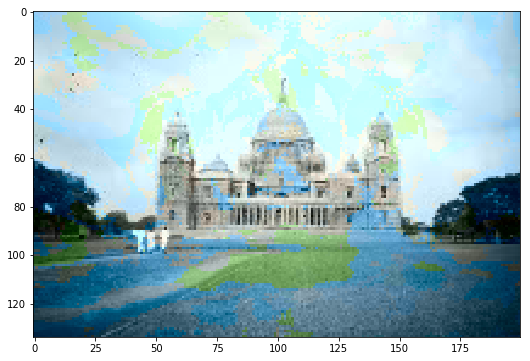

In [5]:
l,a,b=c.predict_im('vic2.jpg')
res=np.zeros((l.shape[0],l.shape[1],3),dtype=uint8)
res[:,:,0]=(l).astype(np.uint8)
res[:,:,1]=(a).astype(np.uint8)
res[:,:,2]=(b).astype(np.uint8)
colorized=cv2.cvtColor(res,cv2.COLOR_Lab2RGB)
plt.imshow(colorized)
plt.show()

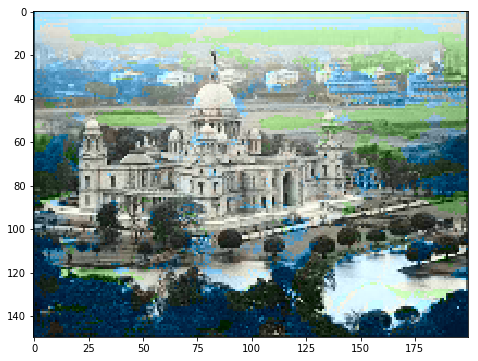

In [6]:
l,a,b=c.predict_im('vic1.jpg')
res=np.zeros((l.shape[0],l.shape[1],3),dtype=uint8)
res[:,:,0]=(l).astype(np.uint8)
res[:,:,1]=(a).astype(np.uint8)
res[:,:,2]=(b).astype(np.uint8)
colorized=cv2.cvtColor(res,cv2.COLOR_Lab2RGB)
plt.imshow(colorized)
plt.show()